## Introduction

Style transfer consists in generating an image
with the same "content" as a base image, but with the
"style" of a different picture (typically artistic).
This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss":

- The total variation loss imposes local spatial continuity between
the pixels of the combination image, giving it visual coherence.
- The style loss is where the deep learning keeps in --that one is defined
using a deep convolutional neural network. Precisely, it consists in a sum of
L2 distances between the Gram matrices of the representations of
the base image and the style reference image, extracted from
different layers of a convnet (trained on ImageNet). The general idea
is to capture color/texture information at different spatial
scales (fairly large scales --defined by the depth of the layer considered).
- The content loss is a L2 distance between the features of the base
image (extracted from a deep layer) and the features of the combination image,
keeping the generated image close enough to the original one.

**Reference:** [A Neural Algorithm of Artistic Style](
  http://arxiv.org/abs/1508.06576)


## Setup


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = "modi.jpeg"
style_reference_image_path = "monalisa.jpeg"
# name of the generated image
result_prefix = "generated_image"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


## Let's take a look at our base (content) image and our style reference image


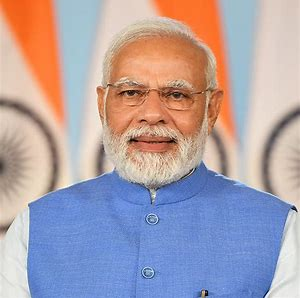

In [2]:
from IPython.display import Image, display

display(Image(base_image_path))


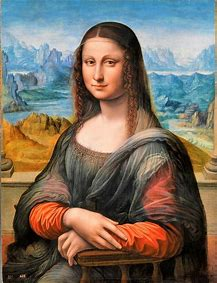

In [3]:
display(Image(style_reference_image_path))

## Image preprocessing / deprocessing utilities


In [4]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



## Compute the style transfer loss

First, we need to define 4 utility functions:

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures
of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated
image locally-coherent


In [5]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))



Next, let's create a feature extraction model that retrieves the intermediate activations
of VGG19 (as a dict, by name).


In [6]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 68s 1us/step


Finally, here's the code that computes the style transfer loss.


In [7]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss



## Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.


In [8]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads



## The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the
resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.


In [9]:
import tensorflow as tf

# Check if GPU is being used
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [ ]:
from tqdm import tqdm

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 50000
for i in tqdm(range(1, iterations + 1)):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])

    # save image after every 1000 steps
    if i % 1000 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
        display(Image(fname))


  0%|                                                                           | 50/50000 [07:04<119:26:31,  8.61s/it]

After 50000 iterations, you get the following result:


In [ ]:
display(Image(result_prefix + "_at_iteration_50000.png"))


## **NOTE** : This architecture of NST is very slow and takes hours of iterations for generating a good enough image. For our web app,we'll try to use a pre-trained Fast-NST model from tensorflow hub. 